<a href="https://colab.research.google.com/github/sir-sauc3/cap-comp215/blob/main/Sos%26RobertoProject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sos' and Roberto's Project 2
##A Simple Grazing Model

####Objectives
* to develop a Cellular Automata model of grazing
* to experiment with intervention policies, like culls to examine their effect

####Pre-req
* Review Ch. 8 Diffusion and Ch. 11.5: Sugarscape (from textbook On Complexity)
* Complete Labs 7-8 – this provides the framework used for this project

###Starting point:

Develop a 2D np array of a grassland

Introduce deer into the grassland with a certain weight index W

###During run:

Deer move randomly in a cardinal motion and graze. Weight index increases (can get up to a maximum weight M)

While not grazing, deer look for more grass and their weight index decreases in each time step (deer die if W gets to 0)

Grass regrows in random areas with a certain probability p


###Goal:

Find a stable, self-regulating deer population (varying model parameters and initial conditions)

In [25]:
import numpy as np
from dataclasses import dataclass
from pprint import pprint
import random

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

In [58]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap='Blues',
    interpolation='none',
    origin='upper',
)


def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [27]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step*self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [78]:
class GrazingSimulation:
  
  DRY = 0
  GRASS = 1
  TALLGRASS = 2

  kernel = [
            [0,1,0],
            [1,0,1],
            [0,1,0]
          ]

  normal_grass_coverage = 0.2
  tallgrass_coverage = 0.1


  # Define a colour map that maps each cell state to an intuitive colour.
  #cornsilk - rgb(255,248,220) -> dry land
  #lime - rgb(0,255,0) -> grass
  #darkgreen - rgb(0,100,0) -> tallgrass
  #brown - rgb(165,42,42) -> deer
  cmap = [(225/225, 248/255, 220/255), (0, 1, 0), (0, 100/255, 0)] 
  field_color_map = matplotlib.colors.ListedColormap(cmap)

  

  def __init__(self, size, deer_amt, deer_weight):
    self.grassland = np.random.choice((self.GRASS ,self.TALLGRASS, self.DRY), (size, size), p=(self.normal_grass_coverage, self.tallgrass_coverage, 1-(self.normal_grass_coverage+self.tallgrass_coverage)))
    self.size = size
    self.deer_amt = deer_amt
    self.deer_weight = deer_weight

    print(self.grassland)
  
    movementRate : int
    weightLossRate : int
    M : int
    N = random.randint(20,40)
  
    self.deer = np.zeros((size, size))
    self.positions = np.random.choice(size**2, size=deer_amt, replace=False)
    for pos in self.positions:
        x, y = divmod(pos, size)
        self.deer[x, y] = deer_weight

  def step(self):
    """Executes one time step, applying the CA rules to regenerate and burn forest."""
    # TODO: define the rules for the CA.  This is a significant challenge b/c there are 4 rules and they must act independently!
    # self.occupiedList.append(self.num_occupied()) # appending num occupied to master list

    occupied = self.grassland == self.GRASS
    bush = self.grassland == self.TALLGRASS
    empty = self.grassland == self.DRY
    grass2bush = 0.05
    dry2grass = 0.09
    # correlated_matrix = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
    # burning_neighbour = correlated_matrix > 4
    
    self.grassland[occupied] = np.random.choice([self.TALLGRASS, self.GRASS], self.grassland[occupied].shape, p=(grass2bush, 1-grass2bush))
    self.grassland[empty] = np.random.choice([self.GRASS, self.DRY], self.grassland[empty].shape, p=(dry2grass, 1-dry2grass))
    # self.array[occupied & burning_neighbour] = self.FIRE #sets cell with tree and burning neighbours on fire on next step
    # self.array[onFire] = self.EMPTY

  # def draw(self, axes=None, step=''):
  #     """Draws the CA cells using the forest colour map so values are coloured intuitively."""
  #     axes = axes or plt.axes
  #     title = f'Time:{step}' #Occupied: {round(self.pct_occupied() * 100, 2)}%'
  #     plot_2D_array(self.grassland, axes=axes, title=title,
  #                   cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))
  #     fig, ax = plt.subplots()
  #     ax.imshow(self.grassland, cmap='Greens')
  #     deer_xs, deer_ys = np.where(self.deer > 0)
  #     ax.scatter(deer_ys, deer_xs, marker='o', color='brown')
  #     plt.show()

  def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step}' #Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.grassland, axes=axes, title=title,
                      cmap=self.field_color_map, vmin=0, vmax=len(self.field_color_map.colors))


  def plot_grass_deer(grass, deer):
    fig, ax = plt.subplots()
    ax.imshow(grass, cmap='Greens')
    deer_xs, deer_ys = np.where(deer > 0)
    ax.scatter(deer_ys, deer_xs, marker='o', color='brown')
    plt.show()


  def plot_grassland(self):
      # fig, ax = plt.subplots()
      # ax.imshow(self.grassland, cmap='Greens')

      # for i in range(self.size):
      #     for j in range(self.size):
      #         if self.deer[i, j] > 0:
      #             # Add small random offset to x and y coordinates
      #             x_offset, y_offset = np.random.uniform(low=-0.5, high=0.5, size=2)
      #             x = i + x_offset
      #             y = j + y_offset
      #             ax.add_artist(plt.Circle((y, x), radius=0.4, color='black'))
      #             ax.text(y, x, f"{self.deer[i,j]:.1f}", ha='center', va='center', color='white')

      # plt.show()
      # Create reference matrix for deer
      deer_ref = np.zeros((self.size, self.size), dtype=bool)
      for pos in self.positions:
        x, y = divmod(pos, self.size)
        deer_ref[x+0.5, y+0.5] = True
      # for x, y in self.positions:
      #     deer_ref[x, y] = True
          
      # Plot grassland and deer
      fig, ax = plt.subplots(figsize=(8, 8))
      ax.imshow(self.grassland, cmap='Greens')

      # Plot deer as black circles with mass in the center
      for i in range(self.size):
          for j in range(self.size):
              if deer_ref[i, j]:
                  circle = plt.Circle((j+0.5, i+0.5), 0.5, color='black', fill=True)
                  ax.add_artist(circle)
                  ax.text(j+0.5, i+0.5, f'{self.deer[i, j]:.1f}', ha='center', va='center', color='white')


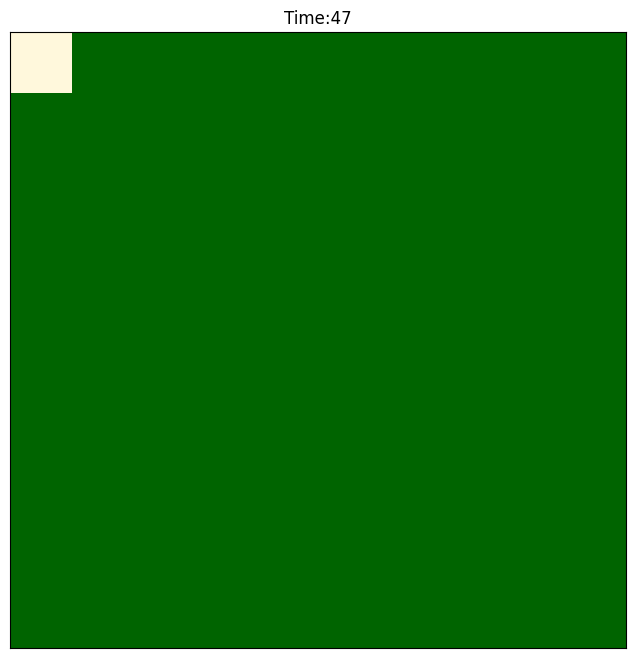

In [ ]:
grassland_size = 10
# grass_coverage = 0.5 #between 0 <= grass_coverage <= 1
no_deer = 10
deer_weight = 50

test = GrazingSimulation(grassland_size, no_deer, deer_weight)
print(test)
graze = Animation2D(test)

graze.animate(5)
# print(test.grassland)
# # visual = Animation2D(test)
# # visual.animate()

# test.plot_grassland()

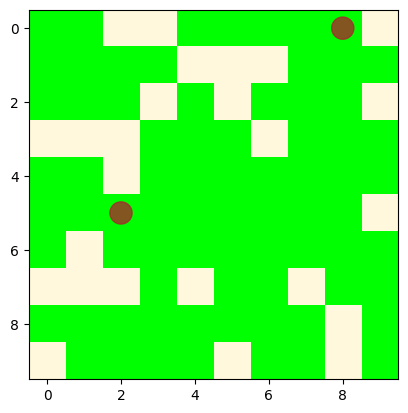

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Define the size of the map
n_rows = 10
n_cols = 10

# Generate sample data for grass and dry land
q = 0.3
area = np.random.choice([1,0], (n_rows, n_cols), p=(q, 1-q))

# Choose a random subset of grass cells to place animals on
n_animals = 2  # number of animals to place
animal_indices = np.random.choice(np.arange(n_rows * n_cols), size=n_animals, replace=False)
animal_rows, animal_cols = np.unravel_index(animal_indices, (n_rows, n_cols))

# Create the animals array with zeros everywhere except for the selected cells
animals = np.zeros_like(area)
animals[animal_rows, animal_cols] = 1

# Create a color map for grass and dry land
cmap = mcolors.ListedColormap(['lime', 'cornsilk'])

# Plot the grass and dry land arrays as images
fig, ax = plt.subplots()
ax.imshow(area, cmap=cmap) #, interpolation='nearest')
# ax.axis('off')

# Add circles for the animals
radius = 0.3  # radius of the animal circles
deer_ref = animals[animals==1]  #finding the cells that have deer in them
for i in range(animals.shape[0]): #checks all the rows
    for j in range(animals.shape[1]): #checks all the cols
        if animals[i, j] == 1:
            # Compute the center of the circle based on the cell's position
            x = j
            y = i
            center = (x, y)
            
            # Create the circle and add it to the plot
            circle = mpatches.Circle(center, radius, color='brown', alpha=0.8)
            ax.add_patch(circle)


# Show the plot
plt.show()

###################



In [ ]:
# Grazing simulation class
# Animation class that takes a 

In [31]:
print(animals[animals==1])
print(animals)

print(np.where(animals==1))
indices = np.where(animals == 1)

# get the x and y coordinates from the indices and add 0.5 to get the center
x_center = indices[1]
y_center = indices[0]
# create a list of the center coordinates as tuples
centers = list(zip(x_center, y_center))
print(f'centers: {centers}')
print(len(centers))
# for _ in range(len(animals[animals==1])):
#   print(animals[animals==1].animal_rows)

[1 1]
[[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
(array([0, 5]), array([8, 2]))
centers: [(8, 0), (2, 5)]
2


In [32]:
# print(test.grassland > 0)
# print(test.grassland[test.grassland == 1])

In [33]:
# test = Grazing2D(1,1,1)
# # print(test.field)

# model = Animation2D(test)
# model.animate()

In [34]:
#STUFF I NEED TO DO

# 1. Create a grassland
# 2. Find a way to introduce deer onto the grassaland (each with a weight index of W)
# 3. Find a way to make the deer move via a random walk
# 4. When deer graze, the weight index increases to M (i guess i can choose the rate at which it increases)
# 5. When its not grazing (looking for food), W decreases (i guess i chose this rate too)
# 6. Deer dies when W gets to 0


# HOW IM GOING TO DO IT

# 1. create an np array and randomly fill it from 0-3. 0 for no grass, 3 for most grass. using np.random.choice()

In [35]:
# grassland = np.random.choice([0,1,2,3], (15,15), p=[0.5, 0.3, 0.1, 0.1])

# print(grassland)

In [36]:
@dataclass
class Point2D:
    """ A point on the 2D Cartesian plane """
    x: int
    y: int

    def __add__(self, other):
        """ Define the + operator for two points - vector addition """
        return Point2D(self.x + other.x, self.y + other.y)

In [37]:
# N, S, E, W
CARDINAL_NEIGHBOURS = (Point2D(0, 1), Point2D(0, -1), Point2D(1, 0), Point2D(-1, 0))

def random_walk(p):
    """ "walk" point p 1-step, to a neighbouring cardinal locaction (lattice random walk) """
    return p + np.random.choice(CARDINAL_NEIGHBOURS)

We create a GrassField class that initializes the area in which

In [38]:
@dataclass
class GrassField:
  DRY = 0
  GRASS = 1
  TALLGRASS = 2
  
  def __init__(self, size, pGrass = 0.5, pTall = 0.1):
    self.field = np.random.choice((self.GRASS, self.TALLGRASS, self.DRY), (size, size), p = [pGrass, pTall, 1-(pGrass+pTall)])

    self.covered = self.field[self.field==self.GRASS]
    self.bare = self.field[self.field==self.DRY]


  def spawnGrass(self, pctOfSize):
    grasses = len(self.field)**2 * pctOfSize #gets total number of cells of the grassland and gets a percentage of those cells to regrow
    self.field[self.field==self.DRY] = np.random.choice([self.GRASS, self.DRY], self.bare.shape, p=(pctOfSize, 1-pctOfSize))
    


In [39]:
test = GrassField(10)
print(test.field)
print(f'no. of bare = {len(test.field[test.field==0])}')
print('\n')
test.spawnGrass(.50)
print(test.field)
print(f'no. of bare = {len(test.field[test.field==0])}')

[[1 1 0 1 0 0 0 1 1 1]
 [0 0 0 0 2 0 1 1 1 2]
 [0 0 1 0 1 0 0 0 0 1]
 [1 0 1 0 0 2 0 0 0 0]
 [1 1 0 1 0 2 1 1 1 1]
 [1 0 1 1 0 1 1 0 0 1]
 [1 1 0 1 1 1 1 0 1 0]
 [0 1 0 0 0 1 1 0 0 1]
 [0 0 1 1 0 1 0 1 1 2]
 [1 0 1 0 0 2 0 0 0 0]]
no. of bare = 49


[[1 1 0 1 1 1 0 1 1 1]
 [0 1 0 1 2 0 1 1 1 2]
 [0 1 1 0 1 0 0 1 1 1]
 [1 1 1 1 0 2 1 1 1 0]
 [1 1 0 1 0 2 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 0 1 1 2]
 [1 1 1 1 0 2 0 1 0 1]]
no. of bare = 19


In [40]:
@dataclass
class Deer:
  NONEXISTENT = 0
  DEATHWEIGHT = 3
  W : int
  M : int
  metabolism : int
  x : int
  y : int
  
  def __init__(self, M, W, metaboolism):
    self.M = M
    self.W = W
    self.metabolism = metaboolism

  def loseWeight(self):
    self.W -= self.metabolism

  def gainWeight(self):
    self.W += self.metabolism #i think this should equal the number of the cell it is on

  def randomWalk(self):
    # do random x or y
    # do random +1 -1
    xyChoice = random.choice([x, y])
    addChoice = random.choice([-1, 1])

    xyChoice += addChoice

  

In [41]:
@dataclass
class deerField:
  EMPTY = 0
  DEATHWEIGHT = 3

  def __init__(self,size, n, M, W, metabolsm):
    """
    size = size of grassland
    n = no. of deer
    M = max weight
    W = current weight
    metabolism = amount of weight loss per step
    """
    self.field = np.random.choice(np.arange(size * size), size=n, replace=False)
    self.field = np.zeros((size, size))
    indices = np.random.choice(size*size, size=n, replace=False) 
    self.field.flat[indices] = np.ones(n) * W  # set the chosen indices to W

    self.M = M
    self.W = W

  def step(self):

    #find indices for each deer. does not preserve Weight value of deer.
    indices = np.where(self.field[self.field > 3])
    deathIndices = np.where(self.field[self.field == 3])
    self.field[deathIndices] = None
    # get the x and y coordinates from the indices and add 0.5 to get the center
    x_center = indices[1]
    y_center = indices[0]
    # create a list of the center coordinates as tuples
    centers = list(zip(x_center, y_center))
    
# integrate Deer class into deerField instead of using their weight to keep track
# make them graze (operation on the grassField, then gain weight, lose weight otherwise)
# animate the entire model !



# N, S, E, W
# CARDINAL_NEIGHBOURS = (Point2D(0, 1), Point2D(0, -1), Point2D(1, 0), Point2D(-1, 0))

# def random_walk(p):
#     """ "walk" point p 1-step, to a neighbouring cardinal locaction (lattice random walk) """
#     return p + np.random.choice(CARDINAL_NEIGHBOURS)



testDeer = deerField(5, 5, 30, 10, 1)
print(testDeer.field)

[[ 0.  0.  0.  0. 10.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.]
 [ 0.  0.  0. 10.  0.]
 [10.  0. 10.  0.  0.]]


In [42]:
haha = deerField()

TypeError: ignored

want to be able to create a deer dataclass

input random no. of deer that we want. deer get generated and assigned random ints for their location without repeating it